<a href="https://colab.research.google.com/github/Daniel-Karlik/01NAEX/blob/main/classification/SU2_classifying_German_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebooks deals with pretraining image classification for german traffic signs

## Loading German traffic sign dataset from kaggle

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 612M/612M [00:27<00:00, 25.4MB/s]
100% 612M/612M [00:27<00:00, 23.4MB/s]


In [6]:
%%capture
! unzip gtsrb-german-traffic-sign.zip

In [7]:
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn
from PIL import Image

In [8]:
classes_names = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [9]:
df_train = pd.read_csv('/content/Train.csv', sep=',', delimiter=None, encoding="utf8")

print(df_train.sample(10))

       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
25204     37      39       5       6      32      33       17   
15557     40      41       5       6      35      36       10   
33755     27      28       5       6      22      23       33   
253       36      36       6       6      31      31       20   
31747     43      41       5       6      38      36       30   
2027      45      46       5       6      40      41        1   
35579     29      30       5       6      24      25       36   
8528      30      29       5       5      25      24        5   
31475     38      38       5       5      33      33       29   
21664     35      33       6       6      30      28       13   

                                 Path  
25204  Train/17/00017_00025_00004.png  
15557  Train/10/00010_00017_00017.png  
33755  Train/33/00033_00022_00006.png  
253    Train/20/00020_00008_00013.png  
31747  Train/30/00030_00004_00007.png  
2027    Train/1/00001_00048_00017.png  
3557

In [10]:
df_train['Path'] = '/content/' + df_train['Path'].astype(str)

In [11]:
print(df_train.sample(10))

       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
38788     81      84       7       8      74      77       41   
7761      52      51       6       5      47      46        4   
20385     46      45       5       5      41      40       12   
33342     58      58       6       5      53      53       33   
18768     41      40       6       5      36      35       12   
18953     72      69       7       6      66      63       12   
36526     45      44       6       5      40      39       38   
15134     36      38       5       6      30      32       10   
13677     62      60       5       5      57      55        9   
2508      43      43       5       5      38      38        1   

                                          Path  
38788  /content/Train/41/00041_00001_00029.png  
7761    /content/Train/4/00004_00043_00021.png  
20385  /content/Train/12/00012_00067_00015.png  
33342  /content/Train/33/00033_00008_00012.png  
18768  /content/Train/12/00012_00013_00

In [12]:
df2 = df_train[['ClassId', 'Path']]

In [13]:
df2.head()

,ClassId,Path
0,20,/content/Train/20/00020_00000_00000.png
1,20,/content/Train/20/00020_00000_00001.png
2,20,/content/Train/20/00020_00000_00002.png
3,20,/content/Train/20/00020_00000_00003.png
4,20,/content/Train/20/00020_00000_00004.png


For the time reasons we used 50% of all available data e.g almost 20K images.


In [14]:
df = df2.sample(frac=0.5)

In [15]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, X, y, BatchSize, transform):
    super().__init__()
    self.BatchSize = BatchSize
    self.y = y
    self.X = X
    self.transform = transform
    
  def num_of_batches(self):
    """
    Detect the total number of batches
    """
    return math.floor(len(self.list_IDs) / self.BatchSize)

  def __getitem__(self,idx):
    class_id = self.y[idx]
    img = Image.open(self.X[idx])
    img = self.transform(img)
    return img, torch.tensor(int(class_id))

  def __len__(self):
    return len(self.X)

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Shuffeling our dataframe
df = df.sample(frac=1)

X = df.iloc[:,1]
y = df.iloc[:,0]

transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.RandomRotation(20, fill=256),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(),
                transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
                transforms.Normalize([0.5], [0.5])
            ])

test_transform = transforms.Compose([
                              transforms.Resize([256,256]),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, stratify = y, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0)

dataset_stages = ['train', 'val', 'test']

batch_size = 32
image_datasets = {'train' : CustomDataset(X_train.values, y_train.values, batch_size, transform), 'val' : CustomDataset(X_val.values, y_val.values, batch_size, test_transform), 'test' : CustomDataset(X_test.values, y_test.values, batch_size, test_transform)}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=image_datasets[x].BatchSize,
                                            shuffle=True, num_workers=0)
            for x in dataset_stages}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

Showing one of our training images

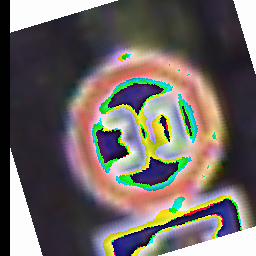

In [17]:
import matplotlib.pyplot as plt
nparray = image_datasets['train'][2][0].cpu().numpy() 
image = transforms.ToPILImage()(image_datasets['train'][2][0].cpu()).convert("RGB")
display(image)

In [18]:
image_datasets['train'].y

array([27,  8,  1, ...,  8,  8, 28])

In [19]:
classes_names

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing veh over 3.5 tons',
 11: 'Right-of-way at intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Veh > 3.5 tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve left',
 20: 'Dangerous curve right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End speed + passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right'

One of our testing image

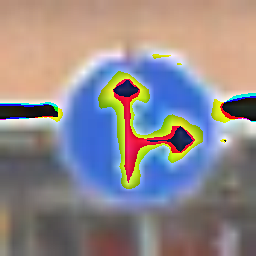

In [20]:
import matplotlib.pyplot as plt
image = transforms.ToPILImage()(image_datasets['test'][2][0].cpu()).convert("RGB")
display(image)

In [22]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
  since = time.time()
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0
          num_batches = 0
          outputs = None
          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              # Loading Bar
              if (phase == 'train'):
                num_batches += 1
                percentage_complete = ((num_batches * batch_size) / (dataset_sizes[phase])) * 100
                percentage_complete = np.clip(percentage_complete, 0, 100)
                print("{:0.2f}".format(percentage_complete), "% complete", end="\r")
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()
              
              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs.float(), labels)

                  # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                  optimizer.step()
              running_loss += loss.item() * inputs.size(0)
              
              predicted = torch.max(outputs.data, 1)[1] 
              running_correct = (predicted == labels).sum()
              running_corrects += running_correct
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          
          epoch_acc = running_corrects / dataset_sizes[phase]
          #epoch_acc = sum(epoch_acc) / len(epoch_acc)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc.item()))
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  return model

In [23]:
from torchvision import models
from torch.optim import lr_scheduler

Loading pretrained Squeezenet_1.1 model and changing last layer and number of classes for our case

In [24]:
model_ft = models.squeezenet1_1(pretrained=True)
model_ft.classifier._modules["1"] = nn.Conv2d(512, 43, kernel_size=(1, 1))
model_ft.num_classes = 43
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
device

'cuda'

## Trainining model on our data

In [27]:
# criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# num_epoch = 10
# model_ft = train_model(model_ft.to(device), criterion, optimizer_ft, exp_lr_scheduler, num_epoch)

In [28]:
# def freeze_model(model):
#     for parameter in model.parameters():
#         parameter.requires_grad = False

In [29]:
# freeze_model(model_ft)

In [30]:
# PATH = "01SU2_squeezenet_signs_model_germany.pt"

# # Saving our model
# torch.save(model_ft.state_dict(), PATH)

## Loading our trained model

In [27]:
model_ft = models.squeezenet1_1(pretrained=True)
model_ft.classifier._modules["1"] = nn.Conv2d(512, 43, kernel_size=(1, 1))
model_ft.num_classes = 43
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True

In [28]:
model_ft.load_state_dict(torch.load("/content/01SU2_squeezenet_signs_model_germany.pt"))
# NO cuda
#model_ft.load_state_dict(torch.load('/content/01SU2_squeezenet_signs_model_germany.pt', map_location=torch.device('cpu')))

model_ft.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [29]:
model_ft.to(torch.device(device))

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

## Some insight on how well does our model predicts

In [30]:
from sklearn.metrics import accuracy_score 

accuracy_scores = []

running_corrects = 0
outputs = None
for inputs, labels in dataloaders['test']:
    model_ft.eval()
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)

    predicted = torch.max(outputs.data, 1)[1]
    print("predicted:")
    print(predicted)
    print("labels:")
    print(labels)
    running_correct = (predicted == labels).sum()
    running_corrects += running_correct

accuracy = running_corrects / dataset_sizes['test']
print("Accuracy: " + str(accuracy.item()))

predicted:
tensor([26,  5,  7, 33,  5, 25, 20, 38,  8, 10, 11, 17,  4, 17, 41,  4,  1, 16,
         8, 29,  2,  5, 13,  7, 13, 35, 10, 28,  6, 25,  4, 17],
       device='cuda:0')
labels:
tensor([26,  5,  7, 34,  5, 28, 20, 38,  7, 10, 11, 17,  4, 17, 41, 11,  1, 16,
         8, 29,  2,  5, 13,  7, 13, 35, 10, 28,  6, 25,  4, 17],
       device='cuda:0')
predicted:
tensor([ 5, 38,  1, 33, 22,  1, 23, 10, 15,  1, 17,  8, 15,  5,  9, 25, 23,  4,
         0, 34, 13,  7, 14,  2,  9, 35,  8, 11, 12,  3, 33, 35],
       device='cuda:0')
labels:
tensor([ 5, 38,  1, 33, 22,  1, 23, 10, 15,  1, 17,  8, 15,  5,  9, 18, 23,  4,
         0, 34, 13,  7, 14,  2,  9, 35,  8, 25, 12,  3, 33, 35],
       device='cuda:0')
predicted:
tensor([13, 12,  9, 18,  8,  4, 12, 35, 17, 15,  5, 15,  9, 38, 10,  3, 13, 33,
        20, 13,  8, 13,  3, 33,  4, 18,  4, 34,  4,  2, 15,  1],
       device='cuda:0')
labels:
tensor([13, 12,  9, 18,  7,  4, 12, 35, 17, 15,  2, 15,  9, 38, 10,  3, 13, 33,
        20, 13,  8

## Prediction of one image

In [32]:
X_test.head()

18161    /content/Train/11/00011_00037_00011.png
30884    /content/Train/28/00028_00002_00014.png
35645    /content/Train/36/00036_00008_00006.png
8289      /content/Train/4/00004_00061_00009.png
33517    /content/Train/33/00033_00014_00007.png
Name: Path, dtype: object

In [33]:
X_test.iloc[0]

'/content/Train/11/00011_00037_00011.png'

In [34]:
pred_index = X_test.loc[X_test == X_test.iloc[0]].index.values

In [35]:
pred_index = pred_index[0].astype(int)

In [36]:
pred_index

18161

In [37]:
def loading_img(idx):
    class_id = y[idx]
    img = Image.open(X[idx])
    img = test_transform(img)
    return img, torch.tensor(int(class_id))

In [38]:
img, class_pred = loading_img(pred_index)

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds.item()

In [40]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [41]:
from IPython.display import HTML
from base64 import b64encode

def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))


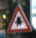

In [42]:
show_image(X[pred_index], width = 300)

In [43]:
print('Label:', class_pred, ', Predicted:', predict_image(img, model_ft))

Label: tensor(11) , Predicted: 11


In [44]:
classes_names

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing veh over 3.5 tons',
 11: 'Right-of-way at intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Veh > 3.5 tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve left',
 20: 'Dangerous curve right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End speed + passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right'

Data are from https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign